# CHAPTER 13: _Pre Processing Methods_

## The Preparations

### Check the Python environment and install the virtual environment

### Installing the Libraries

In [1]:
%%capture
!pip install solas-ai
!pip install fairlearn

# Google Colab Instructions


*   If you are running in a collab environment, you need to manually restart the session after running the previous code cell

*   Select --> Runtime --> Restart Session



### Loading the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, FrozenEstimator

from scipy.stats import zscore
import solas_disparity as sd
from fairlearn.preprocessing import CorrelationRemover

pd.set_option('display.max_columns', None)
np.random.seed(271828)

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

## Importing and Preparing the Data

In [2]:
url = 'https://raw.githubusercontent.com/PacktPublishing/Building-Responsible-AI-with-Python/main/data/consumer_expenditure_survey.csv.gz'
df = pd.read_csv(url, index_col='CUID')
assert df.index.is_unique, "Index is Not Unique"

In [3]:
df.sample(n=5, random_state=314)

,Data,Fold,Date,Year,Month,Income Before Taxes,Number of Bedrooms,Number of Bathrooms,State,Urban,People,Adults,65 or Older,Children,Working,Retired,Education,Race,Sex,Renter,Owner,Food-Away,Food-Home,Food-Total,lead-Food-Away,lead-Food-Home,lead-Food-Total,High lead-Food-Away Spending
CUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269358,Train,5.0,2013-07-01,2013,7,10465.171948,6.0,2.0,Utah,1,1,1,0,0,0,0,Some College,White,Female,1.0,0.0,78.410068,156.820136,235.230204,156.285575,625.142299,781.427873,0
455069,OOT-2020,NaN,2020-09-01,2020,9,31155.283063,3.0,1.0,Michigan,1,2,2,2,0,0,2,Bachelors,White,Mixed Gender,0.0,1.0,861.867714,2628.600151,3490.467866,795.751459,1254.591981,2050.343440,0
318656,Test,NaN,2015-09-01,2015,9,20620.182141,3.0,1.0,New York,1,5,3,0,2,0,0,High School,Black,Mixed Gender,1.0,0.0,0.000000,1501.226116,1501.226116,0.000000,1571.898594,1571.898594,0
321466,Train,5.0,2015-10-01,2015,10,152265.806940,4.0,3.0,Florida,1,2,2,0,0,2,0,Bachelors,Asian/PI,Male,0.0,1.0,1900.233654,2102.925244,4003.158899,1497.716055,1647.487660,3145.203715,0
394719,Train,2.0,2018-12-01,2018,12,351819.092004,3.0,2.0,Texas,1,3,3,0,0,3,0,Bachelors,White,Mixed Gender,0.0,1.0,3253.744273,2025.179779,5278.924052,3057.111121,3985.361225,7042.472347,1


## Feature pre-processing

### Race Feature Encoding

In [4]:
df['Race'].unique()

array(['White', 'Black', 'Asian/PI', 'Multi or Other Race'], dtype=object)

In [5]:
df['Black'] = (df['Race'] == 'Black').astype(int)
df['White'] = (df['Race'] == 'White').astype(int)
df['Other Race'] = 1 - df[['Black', 'White']].sum(axis=1)
df['All Observations'] = 1

In [6]:
df.sample(n=5, random_state=1234)

,Data,Fold,Date,Year,Month,Income Before Taxes,Number of Bedrooms,Number of Bathrooms,State,Urban,People,Adults,65 or Older,Children,Working,Retired,Education,Race,Sex,Renter,Owner,Food-Away,Food-Home,Food-Total,lead-Food-Away,lead-Food-Home,lead-Food-Total,High lead-Food-Away Spending,Black,White,Other Race,All Observations
CUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
296898,Test,NaN,2015-03-01,2015,3,71230.418562,2.0,1.0,Illinois,1,1,1,0,0,1,0,High School,White,Male,1.0,0.0,301.783733,754.459332,1056.243065,301.874060,754.685151,1056.559211,0,0,1,0,1
265210,Train,5.0,2013-06-01,2013,6,358556.424234,5.0,5.0,Utah,1,2,2,2,0,1,1,Graduate Degree,White,Mixed Gender,0.0,1.0,2150.159167,1725.497031,3875.656198,887.150593,2347.040765,3234.191358,0,0,1,0,1
364053,Train,2.0,2017-03-01,2017,3,47669.037081,3.0,2.0,North Carolina,1,2,2,1,0,0,2,Bachelors,White,Mixed Gender,0.0,1.0,965.085756,2447.181739,3412.267496,1017.935906,4016.249404,5034.185310,0,0,1,0,1
424214,OOT-2019,NaN,2019-11-01,2019,11,140795.048048,3.0,2.0,Georgia,1,3,2,0,1,2,0,High School,White,Mixed Gender,0.0,1.0,1433.275731,2579.896315,4013.172046,1172.887799,2422.506576,3595.394375,0,0,1,0,1
429349,OOT-2020,NaN,2020-02-01,2020,2,84039.839505,1.0,1.0,Texas,1,1,1,1,0,0,1,Graduate Degree,White,Male,1.0,0.0,285.000774,641.251741,926.252514,279.749607,629.436616,909.186223,0,0,1,0,1


### Log Transformation

In [7]:
numeric_features = [
    'Income Before Taxes', 'Number of Bedrooms', 'Number of Bathrooms',
    'Renter', 'Owner','Food-Away', 'Food-Home', 'Food-Total', 'Urban',
    'People', 'Adults', '65 or Older', 'Children', 'Working', 'Retired'
]

select_numeric_features = [f for f in numeric_features if df[f].nunique() > 100]
z_scores = df[select_numeric_features].apply(zscore)
outliers = (z_scores.abs() > 3).sum()

print("Number of outliers per feature:")
print(outliers)

Number of outliers per feature:
Income Before Taxes    335
Food-Away              314
Food-Home              257
Food-Total             261
dtype: int64


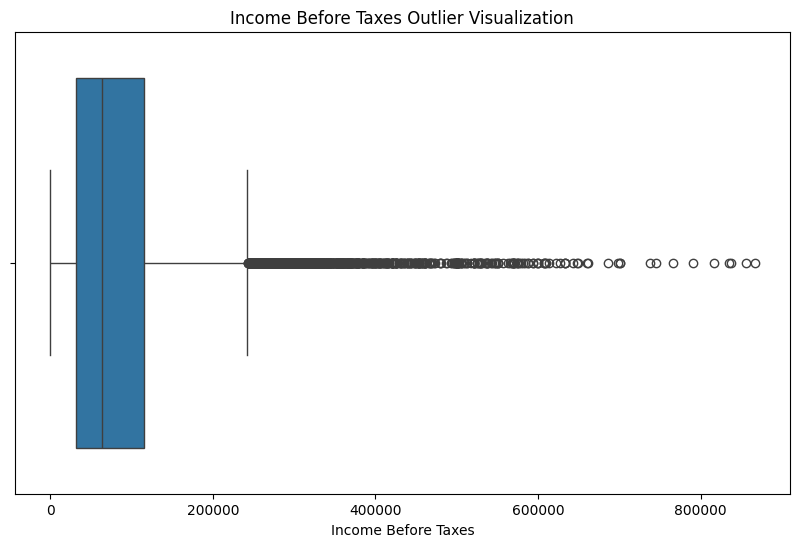

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Income Before Taxes'])
plt.title("Income Before Taxes Outlier Visualization")
plt.show()

In [9]:
log_feature_names = ['log_' + x for x in select_numeric_features]
df[log_feature_names] = np.log(df[select_numeric_features] + 1)  # add 1 to avoid log(0)

In [10]:
df[select_numeric_features+log_feature_names].sample(n=5, random_state=1234)

,Income Before Taxes,Food-Away,Food-Home,Food-Total,log_Income Before Taxes,log_Food-Away,log_Food-Home,log_Food-Total
CUID,,,,,,,,
296898,71230.418562,301.783733,754.459332,1056.243065,11.173689,5.713019,6.627326,6.963420
265210,358556.424234,2150.159167,1725.497031,3875.656198,12.789844,7.673762,7.453850,8.262728
364053,47669.037081,965.085756,2447.181739,3412.267496,10.772058,6.873253,7.803101,8.135425
424214,140795.048048,1433.275731,2579.896315,4013.172046,11.855068,7.268415,7.855892,8.297586
429349,84039.839505,285.000774,641.251741,926.252514,11.339058,5.655995,6.464980,6.832226


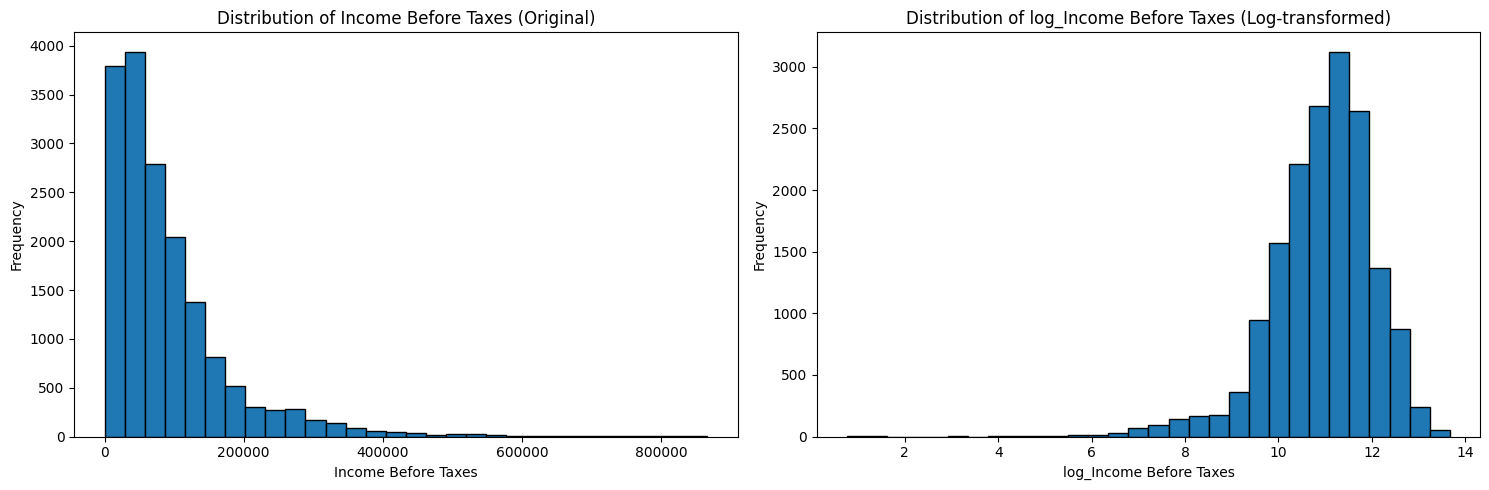

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(df[select_numeric_features[0]], bins=30, edgecolor='black')
plt.title(f'Distribution of {select_numeric_features[0]} (Original)')
plt.xlabel(select_numeric_features[0])
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(df[log_feature_names[0]], bins=30, edgecolor='black')
plt.title(f'Distribution of {log_feature_names[0]} (Log-transformed)')
plt.xlabel(log_feature_names[0])
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Splitting dataset

In [12]:
train = df.loc[df['Data'] == 'Train', :].copy()
valid = df.loc[df['Data'] == 'Test', :].copy()
oot= df.loc[df['Data'].isin(['OOT-2019', 'OOT-2020']), :].copy()
print(train.shape, valid.shape, oot.shape)

(10148, 36) (2579, 36) (4062, 36)


### Target encoding

In [13]:
label  = 'High lead-Food-Away Spending'
target_encode = ['State', 'Education', 'Month']

te = TargetEncoder(
    target_type='binary',
    cv=5,
    shuffle=True,
    random_state=61803,
)
te = te.fit(X=train[target_encode], y=train[label])
te_feature_names = ['te_' + x for x in te.feature_names_in_]

train[te_feature_names] = te.transform(X=train[target_encode])
valid[te_feature_names] = te.transform(X=valid[target_encode])
oot[te_feature_names] = te.transform(X=oot[target_encode])

train[te_feature_names].describe().loc[['min', 'max', 'mean']]

,te_State,te_Education,te_Month
min,0.018467,0.016946,0.074309
max,0.267838,0.185569,0.105877
mean,0.091351,0.091432,0.091445


### Feature scaling

In [14]:
standardize_features = [
    'log_Income Before Taxes', 'Number of Bedrooms', 'Number of Bathrooms',
    'log_Food-Away', 'log_Food-Home', 'log_Food-Total', 'People', 'Adults', '65 or Older',
    'Children', 'Working', 'Retired',
]
standardize_feature_names = ['std_' + x for x in standardize_features]
standardize_feature_names

['std_log_Income Before Taxes',
 'std_Number of Bedrooms',
 'std_Number of Bathrooms',
 'std_log_Food-Away',
 'std_log_Food-Home',
 'std_log_Food-Total',
 'std_People',
 'std_Adults',
 'std_65 or Older',
 'std_Children',
 'std_Working',
 'std_Retired']

In [15]:
ss = StandardScaler()
ss = ss.fit(train[standardize_features])

train[standardize_feature_names] = ss.transform(train[standardize_features])
valid[standardize_feature_names] = ss.transform(valid[standardize_features])
oot[standardize_feature_names] = ss.transform(oot[standardize_features])

In [16]:
train[standardize_feature_names].describe().loc[['min', 'max', 'mean', 'std']].applymap(lambda x: float(f"{x:.2f}"))

,std_log_Income Before Taxes,std_Number of Bedrooms,std_Number of Bathrooms,std_log_Food-Away,std_log_Food-Home,std_log_Food-Total,std_People,std_Adults,std_65 or Older,std_Children,std_Working,std_Retired
min,-9.33,-2.22,-2.28,-2.16,-9.42,-8.85,-1.01,-1.04,-0.58,-0.57,-1.33,-0.52
max,2.51,51.36,9.55,1.85,3.36,4.42,18.58,21.03,5.47,9.07,20.67,4.51
mean,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Feature Imputation

In [17]:
binary_feature_names = ['Urban', 'Renter']

features = standardize_feature_names + binary_feature_names + te_feature_names
display(pd.Series(features))

,0
0,std_log_Income Before Taxes
1,std_Number of Bedrooms
2,std_Number of Bathrooms
3,std_log_Food-Away
4,std_log_Food-Home
5,std_log_Food-Total
6,std_People
7,std_Adults
8,std_65 or Older
9,std_Children


In [18]:
imputer = SimpleImputer(strategy='mean')
imputer = imputer.fit(train[features])

train[features] = imputer.transform(train[features])
valid[features] = imputer.transform(valid[features])
oot[features] = imputer.transform(oot[features])

##  Building Baseline Model

In [19]:
base_params = {
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 36,
    'learning_rate': 0.05,
    'random_state': 271828,
}

base_xgb = xgb.XGBClassifier(
    **base_params
).fit(X=train[features], y=train[label])

base_calibrated_model = CalibratedClassifierCV(
    estimator=FrozenEstimator(base_xgb),
    method='sigmoid'
).fit(X=train[features], y=train[label])

In [20]:
base_pred_train = pd.Series(
    data=base_calibrated_model.predict_proba(X=train[features])[:, 1],
    index=train.index,
)

base_pred_valid = pd.Series(
    data=base_calibrated_model.predict_proba(X=valid[features])[:, 1],
    index=valid.index,
)

base_pred_oot = pd.Series(
    data=base_calibrated_model.predict_proba(X=oot[features])[:, 1],
    index=oot.index,
)

cutoff_percentile = 0.6

base_cutoff = np.quantile(a=base_pred_train, q=(1- cutoff_percentile))
base_offer_train = (base_pred_train >= base_cutoff)
base_offer_valid = (base_pred_valid >= base_cutoff)
base_offer_oot = (base_pred_oot >= base_cutoff)

In [21]:
print(
    f"\nTrain % Offer: {base_offer_train.mean():0.2%}"
    f"\nValid % Offer: {base_offer_valid.mean():0.2%}"
    f"\nOOT % Offer:   {base_offer_oot.mean():0.2%}"
)

base_auc_train = metrics.roc_auc_score(y_true=train[label], y_score=base_pred_train)
base_auc_valid = metrics.roc_auc_score(y_true=valid[label], y_score=base_pred_valid)
base_auc_oot = metrics.roc_auc_score(y_true=oot[label], y_score=base_pred_oot)

print(f'Train AUC: {base_auc_train:.4f}')
print(f'Valid AUC: {base_auc_valid:.4f}')
print(f'OOT AUC:   {base_auc_oot:.4f}')


Train % Offer: 60.00%
Valid % Offer: 58.32%
OOT % Offer:   59.90%
Train AUC: 0.9305
Valid AUC: 0.8949
OOT AUC:   0.8788


# Fairness Assessment

In [22]:
print(
    f"\n{label}: Average for Black Households"
    f"\nTraining:   {train.loc[train['Black'] == 1, label].mean():.2%}"
    f"\nValidation: {valid.loc[valid['Black'] == 1, label].mean():.2%}"
    f"\nOOT:        {oot.loc[oot['Black'] == 1, label].mean():.2%}"
)
print(
    f"\n{label}: Average for White Households"
    f"\nTraining:   {train.loc[train['White'] == 1, label].mean():.2%}"
    f"\nValidation: {valid.loc[valid['White'] == 1, label].mean():.2%}"
    f"\nOOT:        {oot.loc[oot['White'] == 1, label].mean():.2%}"
)


High lead-Food-Away Spending: Average for Black Households
Training:   3.04%
Validation: 3.93%
OOT:        2.18%

High lead-Food-Away Spending: Average for White Households
Training:   9.67%
Validation: 9.03%
OOT:        8.64%


In [23]:
print(f"{label} Percentage Change (OOT vs Training):")
print(
    f"Black Households: {(oot.loc[oot['Black'] == 1, label].mean() / train.loc[train['Black'] == 1, label].mean() - 1):.2%}"
)
print(
    f"White Households: {(oot.loc[oot['White'] == 1, label].mean() / train.loc[train['White'] == 1, label].mean() - 1):.2%}"
)

High lead-Food-Away Spending Percentage Change (OOT vs Training):
Black Households: -28.45%
White Households: -10.63%


#### Base Model Fairness Assessment

In [24]:
testing_info = dict(
    group_data=oot,
    protected_groups=['Black'],
    reference_groups=['White'],
    group_categories=['Race'],
    label=oot[label],
)

In [25]:
base_air = sd.adverse_impact_ratio(
    **testing_info,
    outcome=base_offer_oot,
    air_threshold=0.80,
    percent_difference_threshold=0,
)
display(base_air.summary_table[['Total', 'Average Label', 'Percent Favorable', 'Percent Difference Favorable', 'AIR']])

base_rsmd = sd.residual_standardized_mean_difference(
    **testing_info,
    prediction=base_pred_oot,
    residual_smd_threshold=30.0,
    lower_score_favorable=True,
)
display(base_rsmd.summary_table[['Total', 'Average Prediction', 'Average Label', 'Average Residual', 'Difference in Average Residual', 'Residual SMD', 'Practically Significant']])

,Total,Average Label,Percent Favorable,Percent Difference Favorable,AIR
Group,,,,,
Black,459,0.021786,0.420479,0.197737,0.68015
White,3206,0.086400,0.618216,NaN,NaN


,Total,Average Prediction,Average Label,Average Residual,Difference in Average Residual,Residual SMD,Practically Significant
Group,,,,,,,
Black,459,0.042258,0.021786,-0.020471,-0.016195,-6.4787,No
White,3206,0.090677,0.086400,-0.004276,NaN,NaN,



### Pre-Processing Mitigation - Correlation remover

In [26]:
cr = CorrelationRemover(sensitive_feature_ids=['Black'], alpha=0.9)
cr.fit(train[features + ['Black']])
X_train_cr = cr.transform(train[features + ['Black']])
X_valid_cr = cr.transform(valid[features + ['Black']])
X_oot_cr = cr.transform(oot[features + ['Black']])

X_train_cr = pd.DataFrame(
    data=X_train_cr,
    columns=features,
    index=train.index
)

X_valid_cr = pd.DataFrame(
    data=X_valid_cr,
    columns=features,
    index=valid.index
)

X_oot_cr = pd.DataFrame(
    data=X_oot_cr,
    columns=features,
    index=oot.index
)

In [27]:
feature_comparison = pd.DataFrame()
for f_i in features:
    f_i_values = pd.DataFrame(
        data={
            ('Correlation to Black', 'Original Feature'): np.corrcoef(train[f_i], train['Black'])[0, 1],
            ('Correlation to Black', 'Adjusted Feature'): np.corrcoef(X_train_cr[f_i], train['Black'])[0, 1],
            ('Correlation to Label', 'Original Feature'): np.corrcoef(train[f_i], train[label])[0, 1],
            ('Correlation to Label', 'Adjusted Feature'): np.corrcoef(X_train_cr[f_i], train[label])[0, 1],
            ('Correlation of Adjusted to Original Feature', ''): np.corrcoef(X_train_cr[f_i], train[f_i])[0, 1],
        },
        index=[f_i],
    )
    feature_comparison = pd.concat(
        objs=(feature_comparison, f_i_values),
        axis=0,
    )
feature_comparison.style.format("{:.3f}").background_gradient(cmap='coolwarm').set_properties(**{'text-align': 'center'})

# Building the Adjusted Model

In [28]:
cr_params = {
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 36,
    'learning_rate': 0.05,
    'random_state': 271828,
}

cr_xgb = xgb.XGBClassifier(
    **cr_params
).fit(X=X_train_cr, y=train[label])

cr_calibrated_model = CalibratedClassifierCV(
    estimator=FrozenEstimator(cr_xgb),
    method='sigmoid'
).fit(X=X_valid_cr, y=valid[label])

cr_pred_train = pd.Series(
    data=cr_calibrated_model.predict_proba(X=X_train_cr)[:, 1],
    index=train.index,
)

cr_pred_valid = pd.Series(
    data=cr_calibrated_model.predict_proba(X=X_valid_cr)[:, 1],
    index=valid.index,
)

cr_pred_oot = pd.Series(
    data=cr_calibrated_model.predict_proba(X=X_oot_cr)[:, 1],
    index=oot.index,
)


cr_cutoff = np.quantile(a=cr_pred_train, q=(1 - cutoff_percentile))
cr_offer_train = (cr_pred_train >= cr_cutoff)
cr_offer_valid = (cr_pred_valid >= cr_cutoff)
cr_offer_oot = (cr_pred_oot >= cr_cutoff)

## Adjusted Model Predictive Accuracy  

In [29]:
print(
    f"\nTrain % Offer: {cr_offer_train.mean():0.2%}"
    f"\nValid % Offer: {cr_offer_valid.mean():0.2%}"
    f"\nOOT % Offer: {cr_offer_oot.mean():0.2%}"
)

cr_auc_train = metrics.roc_auc_score(y_true=train[label], y_score=cr_pred_train)
cr_auc_valid = metrics.roc_auc_score(y_true=valid[label], y_score=cr_pred_valid)
cr_auc_oot = metrics.roc_auc_score(y_true=oot[label], y_score=cr_pred_oot)

print(f'Train AUC: {cr_auc_train:.4f}')
print(f'Valid AUC: {cr_auc_valid:.4f}')
print(f'OOT AUC: {cr_auc_oot:.4f}')


Train % Offer: 60.00%
Valid % Offer: 59.36%
OOT % Offer: 60.04%
Train AUC: 0.9292
Valid AUC: 0.8956
OOT AUC: 0.8757


In [30]:
print(f'Base Model Training AUC: {base_auc_train:.4f}')
print(f'Adjusted Model Training AUC: {cr_auc_train:.4f}')
print(f'Base Model Validation AUC: {base_auc_valid:.4f}')
print(f'Adjusted Model Validation AUC: {cr_auc_valid:.4f}')

Base Model Training AUC: 0.9305
Adjusted Model Training AUC: 0.9292
Base Model Validation AUC: 0.8949
Adjusted Model Validation AUC: 0.8956


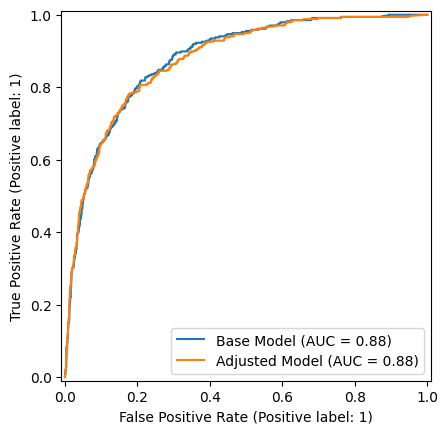

In [31]:
fig, ax = plt.subplots()

metrics.RocCurveDisplay.from_predictions(y_true=oot[label], y_pred=base_pred_oot, ax=ax, name='Base Model')
metrics.RocCurveDisplay.from_predictions(y_true=oot[label], y_pred=cr_pred_oot, ax=ax, name='Adjusted Model')
plt.show()

## Adjusted Model Fairness

## AIR

In [32]:
cr_air = sd.adverse_impact_ratio(
    **testing_info,
    outcome=cr_offer_oot,
    air_threshold=0.80,
    percent_difference_threshold=0,
)

In [37]:
print("Base model AIR")
display(base_air.summary_table[['Total', 'Average Label', 'Favorable', 'Percent Favorable', 'Percent Difference Favorable', 'AIR']])
print('\n' * 2)
print("Adjusted model AIR")
display(cr_air.summary_table[['Total', 'Average Label', 'Favorable', 'Percent Favorable', 'Percent Difference Favorable', 'AIR']])

Base model AIR


,Total,Average Label,Favorable,Percent Favorable,Percent Difference Favorable,AIR
Group,,,,,,
Black,459,0.021786,193,0.420479,0.197737,0.68015
White,3206,0.086400,1982,0.618216,NaN,NaN





Adjusted model AIR


,Total,Average Label,Favorable,Percent Favorable,Percent Difference Favorable,AIR
Group,,,,,,
Black,459,0.021786,239,0.520697,0.087225,0.856519
White,3206,0.086400,1949,0.607923,NaN,NaN


## SMD

In [35]:
cr_rsmd = sd.residual_standardized_mean_difference(
    **testing_info,
    prediction=cr_pred_oot,
    residual_smd_threshold=30.0,
    lower_score_favorable=True,
)

In [38]:
print("Baseline model")
display(base_rsmd.summary_table[['Total', 'Average Prediction', 'Average Label', 'Average Residual', 'Difference in Average Residual', 'Residual SMD']])
print('\n' * 2)
print("Adjusted model")
display(cr_rsmd.summary_table[['Total', 'Average Prediction', 'Average Label', 'Average Residual', 'Difference in Average Residual', 'Residual SMD']])

Baseline model


,Total,Average Prediction,Average Label,Average Residual,Difference in Average Residual,Residual SMD
Group,,,,,,
Black,459,0.042258,0.021786,-0.020471,-0.016195,-6.4787
White,3206,0.090677,0.086400,-0.004276,NaN,NaN





Adjusted model


,Total,Average Prediction,Average Label,Average Residual,Difference in Average Residual,Residual SMD
Group,,,,,,
Black,459,0.047749,0.021786,-0.025962,-0.021005,-8.554546
White,3206,0.091358,0.086400,-0.004958,NaN,NaN


# AIR by Quantile

In [40]:
base_qair = sd.adverse_impact_ratio_by_quantile(
    **testing_info,
    outcome=base_pred_oot,
    air_threshold=0.80,
    percent_difference_threshold=0,
    quantiles=[x / 100 for x in range(1, 101, 1)],
    lower_score_favorable=False,
)
cr_qair = sd.adverse_impact_ratio_by_quantile(
    **testing_info,
    outcome=cr_pred_oot,
    air_threshold=0.80,
    percent_difference_threshold=0,
    quantiles=[x / 100 for x in range(1, 101, 1)],
    lower_score_favorable=False,
)

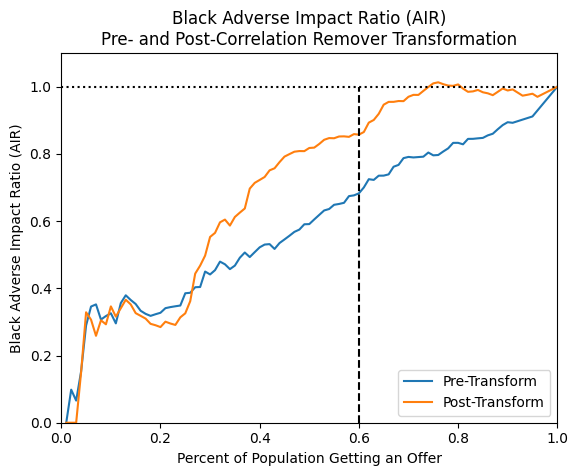

In [45]:
base_qair.summary_table.loc['Black', 'AIR'].plot()
cr_qair.summary_table.loc['Black', 'AIR'].plot()
plt.legend(['Pre-Transform', 'Post-Transform'], loc='lower right')
plt.xlabel('Percent of Population Getting an Offer')
plt.ylabel('Black Adverse Impact Ratio (AIR)')
plt.vlines(x=cutoff_percentile, ymin=0, ymax=1, color='black', linestyle='--')
plt.hlines(y=1, xmin=0, xmax=1, color='black', linestyle='dotted')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.title('Black Adverse Impact Ratio (AIR)\nPre- and Post-Correlation Remover Transformation')
plt.show()